In [1]:
cd ..

/Users/minghuang/Documents/git/SEA_traffic_accident_prediction


In [3]:
from data_processing_scripts import socrata_api_wrapper as saw
from data_processing_scripts import psql_helper as ph 
from data_processing_scripts import footballdb_scraper as fs
from data_processing_scripts import baseball_almanac_scraper as bas
from data_processing_scripts import wunderground_scraper as ws
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
import psycopg2
import seaborn as sns
%matplotlib inline

In [2]:
wunder = ws.WundergroundScraper()
wunder.download_date_range('2009-06-17', '2015-09-14')

data/weather.csv downloaded.


In [8]:
token = 'Opp5gz1KaGplrPjbqnSsWkqHB'

In [9]:
api = saw.SocrataAPI(token)
psql = ph.PsqlConnection(db='traffic_accident', user='minghuang')

Connection Open


### Get 911 response data (original data source intended, traffic accident data seemed insufficient)

In [4]:
r = api.request('https://data.seattle.gov/resource/pu5n-trf4.json')
headers = r.get_headers()
r.set_primary_id('cad_cdw_id')

In [5]:
r.download_csv(file_name='data/raw_911_response.csv')

Download Complete


In [6]:
#psql.drop_table('raw_911_response')
#psql.create_table(headers, 'raw_911_response')
#psql.insert_csv('raw_911_response', '/Users/minghuang/Documents/temp/911calls.csv')

Table raw_911_response dropped.
Table raw_911_response created in traffic_accident
CSV inserted into raw_911_response.


###Get road weather data

In [9]:
r = api.request('https://data.seattle.gov/resource/egc4-d24i.json')
headers = r.get_headers()
r.set_primary_id('recordid')

Connection Open


In [12]:
r.download_csv(file_name='data/raw_road_weather.csv')

Download Complete


In [8]:
#psql.drop_table('raw_road_weather')
#psql.create_table(headers, 'raw_road_weather')
#psql.insert_csv('raw_road_weather', '/Users/minghuang/Documents/temp/roadweather.csv')

Table raw_road_weather dropped.
Table raw_road_weather created in traffic_accident
CSV inserted into raw_road_weather.


###Get Mariner and Seahawks schedule

In [13]:
mariner = bas.BaseballAlmanacScraper()
mariner.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [14]:
seahawks = fs.FootballdbScraper()
seahawks.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [12]:
psql.load_csvs_in_directory('/Users/minghuang/Documents/git/SEA_traffic_accident_prediction/data')

Table raw_traffic_accident dropped.
Table raw_traffic_accident created in traffic_accident
CSV inserted into raw_traffic_accident.


In [13]:
psql.end_connection()

Connection Closed


#EDA

In [63]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
query = "select * from raw_911_response where event_clearance_code like '4%';"
df = pd.read_sql_query(query, con=conn)
conn.close()

In [65]:
df.head()

,cad_cdw_id,at_scene_time,cad_event_number,census_tract,district_sector,event_clearance_code,event_clearance_date,event_clearance_description,event_clearance_group,event_clearance_subgroup,general_offense_number,hundred_block_location,incident_location,initial_type_description,initial_type_group,initial_type_subgroup,latitude,longitude,zone_beat
0,933098,2012-10-08T14:05:00.000,12000344481,2700.6003,J,430,2012-10-08T14:26:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344481,82XX BLOCK OF WALLINGFORD AVE N,"{u'type': u'Point', u'coordinates': [-122.3364...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.689605057,-122.336431336,J1
1,933094,2012-10-08T10:42:00.000,12000344272,9000.3010,E,430,2012-10-08T11:09:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344272,S JACKSON ST / RAINIER AV S,"{u'type': u'Point', u'coordinates': [-122.3141...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.599208685,-122.314137588,E3
2,933093,2012-10-08T10:34:00.000,12000344248,8500.1016,D,430,2012-10-08T10:41:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344248,9 AV / COLUMBIA ST,"{u'type': u'Point', u'coordinates': [-122.3260...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.606980062,-122.326056105,D3
3,933091,2012-10-09T10:26:00.000,12000345578,4100.7004,L,430,2012-10-09T10:46:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012345578,NE 42 ST / 53 AV NE,"{u'type': u'Point', u'coordinates': [-122.2710...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.658716136,-122.271070825,L3
4,933089,2012-10-09T13:12:00.000,12000345782,4100.7004,L,430,2012-10-09T13:48:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012345782,NE 42 ST / 53 AV NE,"{u'type': u'Point', u'coordinates': [-122.2710...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.658716136,-122.271070825,L3
5,933085,2012-10-08T07:13:00.000,12000344077,2700.5000,J,430,2012-10-08T08:13:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344077,N 80 ST / DENSMORE AV N,"{u'type': u'Point', u'coordinates': [-122.3379...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.686918091,-122.33790776,J1
6,933084,2012-10-05T10:48:00.000,12000340255,8900.1008,G,430,2012-10-05T11:17:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012340255,5XX BLOCK OF LAKESIDE AVE S,"{u'type': u'Point', u'coordinates': [-122.2873...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.597259551,-122.287335203,G3
7,933080,2012-10-04T09:33:00.000,12000338807,2600.4006,U,430,2012-10-04T09:58:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012338807,NE 75 ST / 15 AV NE,"{u'type': u'Point', u'coordinates': [-122.3120...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.68304447,-122.312080524,U1
8,933078,2012-10-05T12:02:00.000,12000340391,6800.2003,Q,430,2012-10-05T12:42:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012340391,18XX BLOCK OF 1ST AVE N,"{u'type': u'Point', u'coordinates': [-122.3556...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.635261807,-122.35562275,Q2
9,933077,2012-10-03T11:14:00.000,12000337543,9300.3096,O,430,2012-10-03T11:43:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012337543,47XX BLOCK OF E MARGINAL WAY S,"{u'type': u'Point', u'coordinates': [-122.3394...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.559935547,-122.339440551,O2


In [44]:
len(df.zone_beat.unique())

55

In [23]:
#df.initial_type_description.unique()

In [4]:
lgt = df.longitude.astype(float).values
lat = df.latitude.astype(float).values

In [5]:
print min(lgt), max(lgt)
print min(lat), max(lat)

-122.419091527 -122.237546385
47.496401905 47.734128229


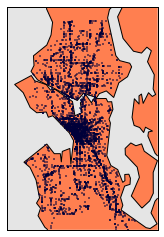

In [6]:
m = Basemap(projection='merc',# lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.45, llcrnrlat=47.5,
    urcrnrlon=-122.2, urcrnrlat=47.75)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

x, y = m(lgt, lat)
m.plot(x, y, 'bo', markersize=1)
 
plt.show()

#### Lets look at my sql transformed data (additional EDA were done in SQL, but not recorded)

In [4]:
query = 'select * from compiled_data;'

In [5]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
df2 = pd.read_sql_query(query, con=conn)
conn.close()

In [6]:
df2 = df2.reindex(np.random.permutation(df2.index))

In [7]:
df2 = df2.sample(100000)

In [8]:
df2.head()

,zone_beat_id,condition_id,winddir_id,hour,dow,month,mariner_plays,seahawk_plays,dewpoint,gustspeed,heatindex,humidity,precip,pressure,temp,visibility,windspeed,label
145259,12,18,1,18,4,10,0,0,52.0,0,0,72,0,30.08,61.0,10,0.0,0
2122755,34,17,14,19,5,4,0,0,39.9,0,0,66,0,29.95,51.1,10,9.2,1
499247,9,2,1,10,3,8,1,0,57.0,0,0,68,0,30.04,68.0,10,0.0,0
2180628,22,17,1,20,4,5,1,0,53.1,0,0,57,0,30.01,69.1,10,0.0,0
1414610,24,2,12,10,6,9,1,0,48.9,0,0,69,0,30.14,59.0,10,8.1,0


In [9]:
df3 = df2[['dewpoint', 'gustspeed', 'heatindex', 'humidity', 'precip', 'pressure', 'temp', 'visibility', 'windspeed', 'label']]

/Users/minghuang/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


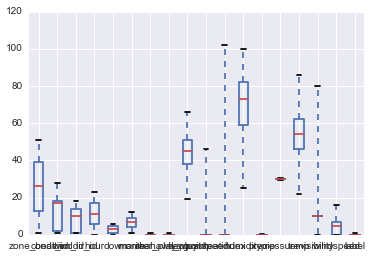

In [10]:
plot = df2.boxplot()

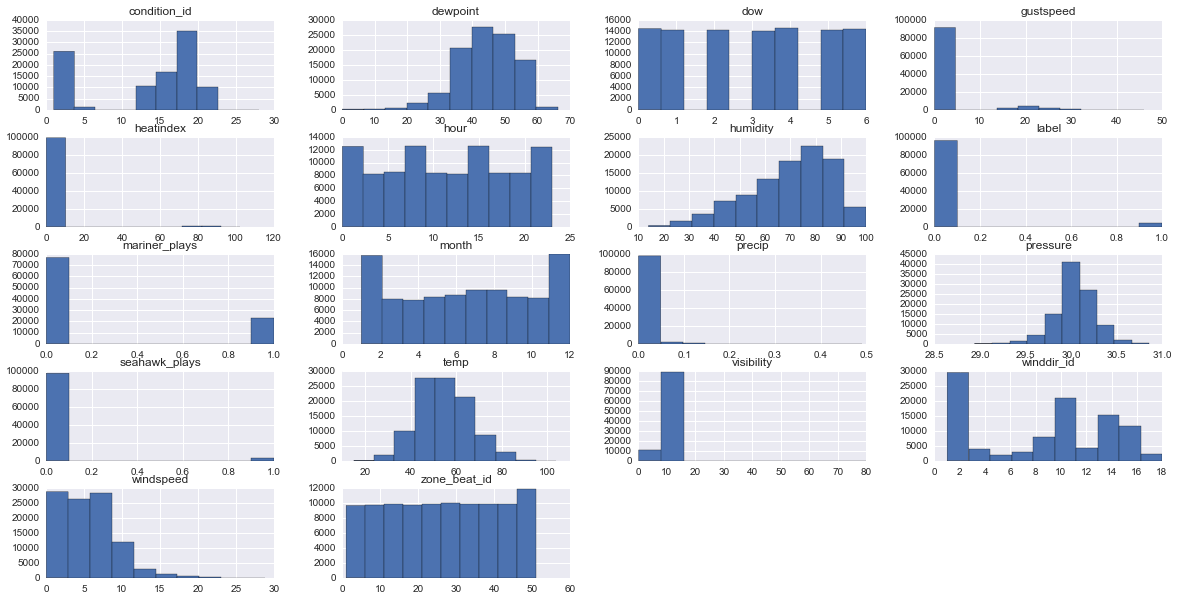

In [11]:
plot = df2.hist(figsize=(20, 10))

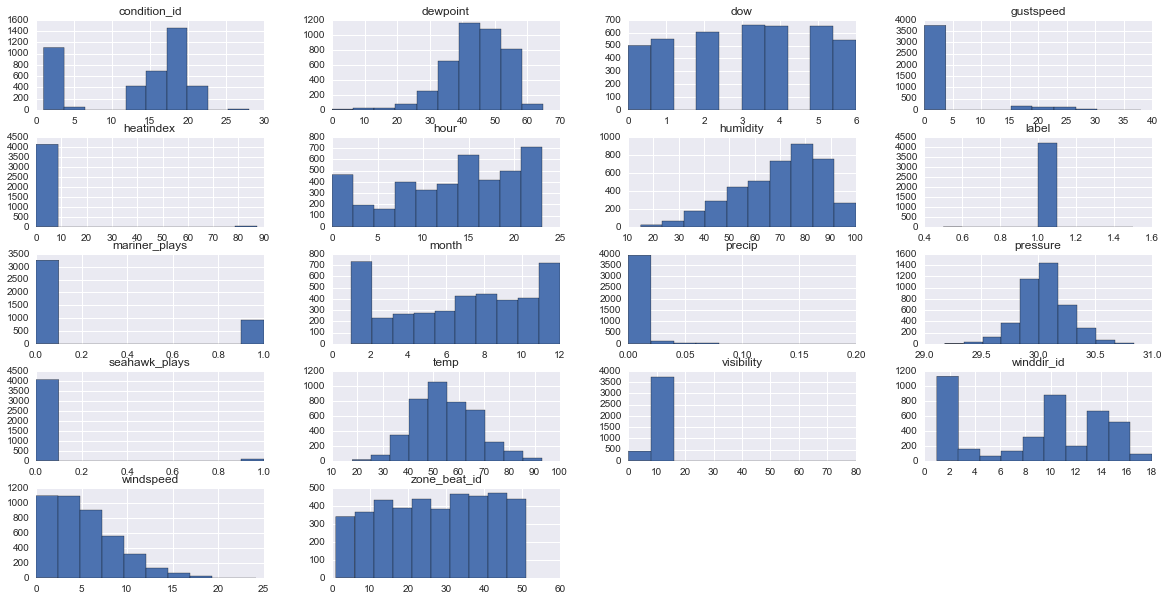

In [12]:
plot = df2[df2.label == 1].hist(figsize=(20, 10))

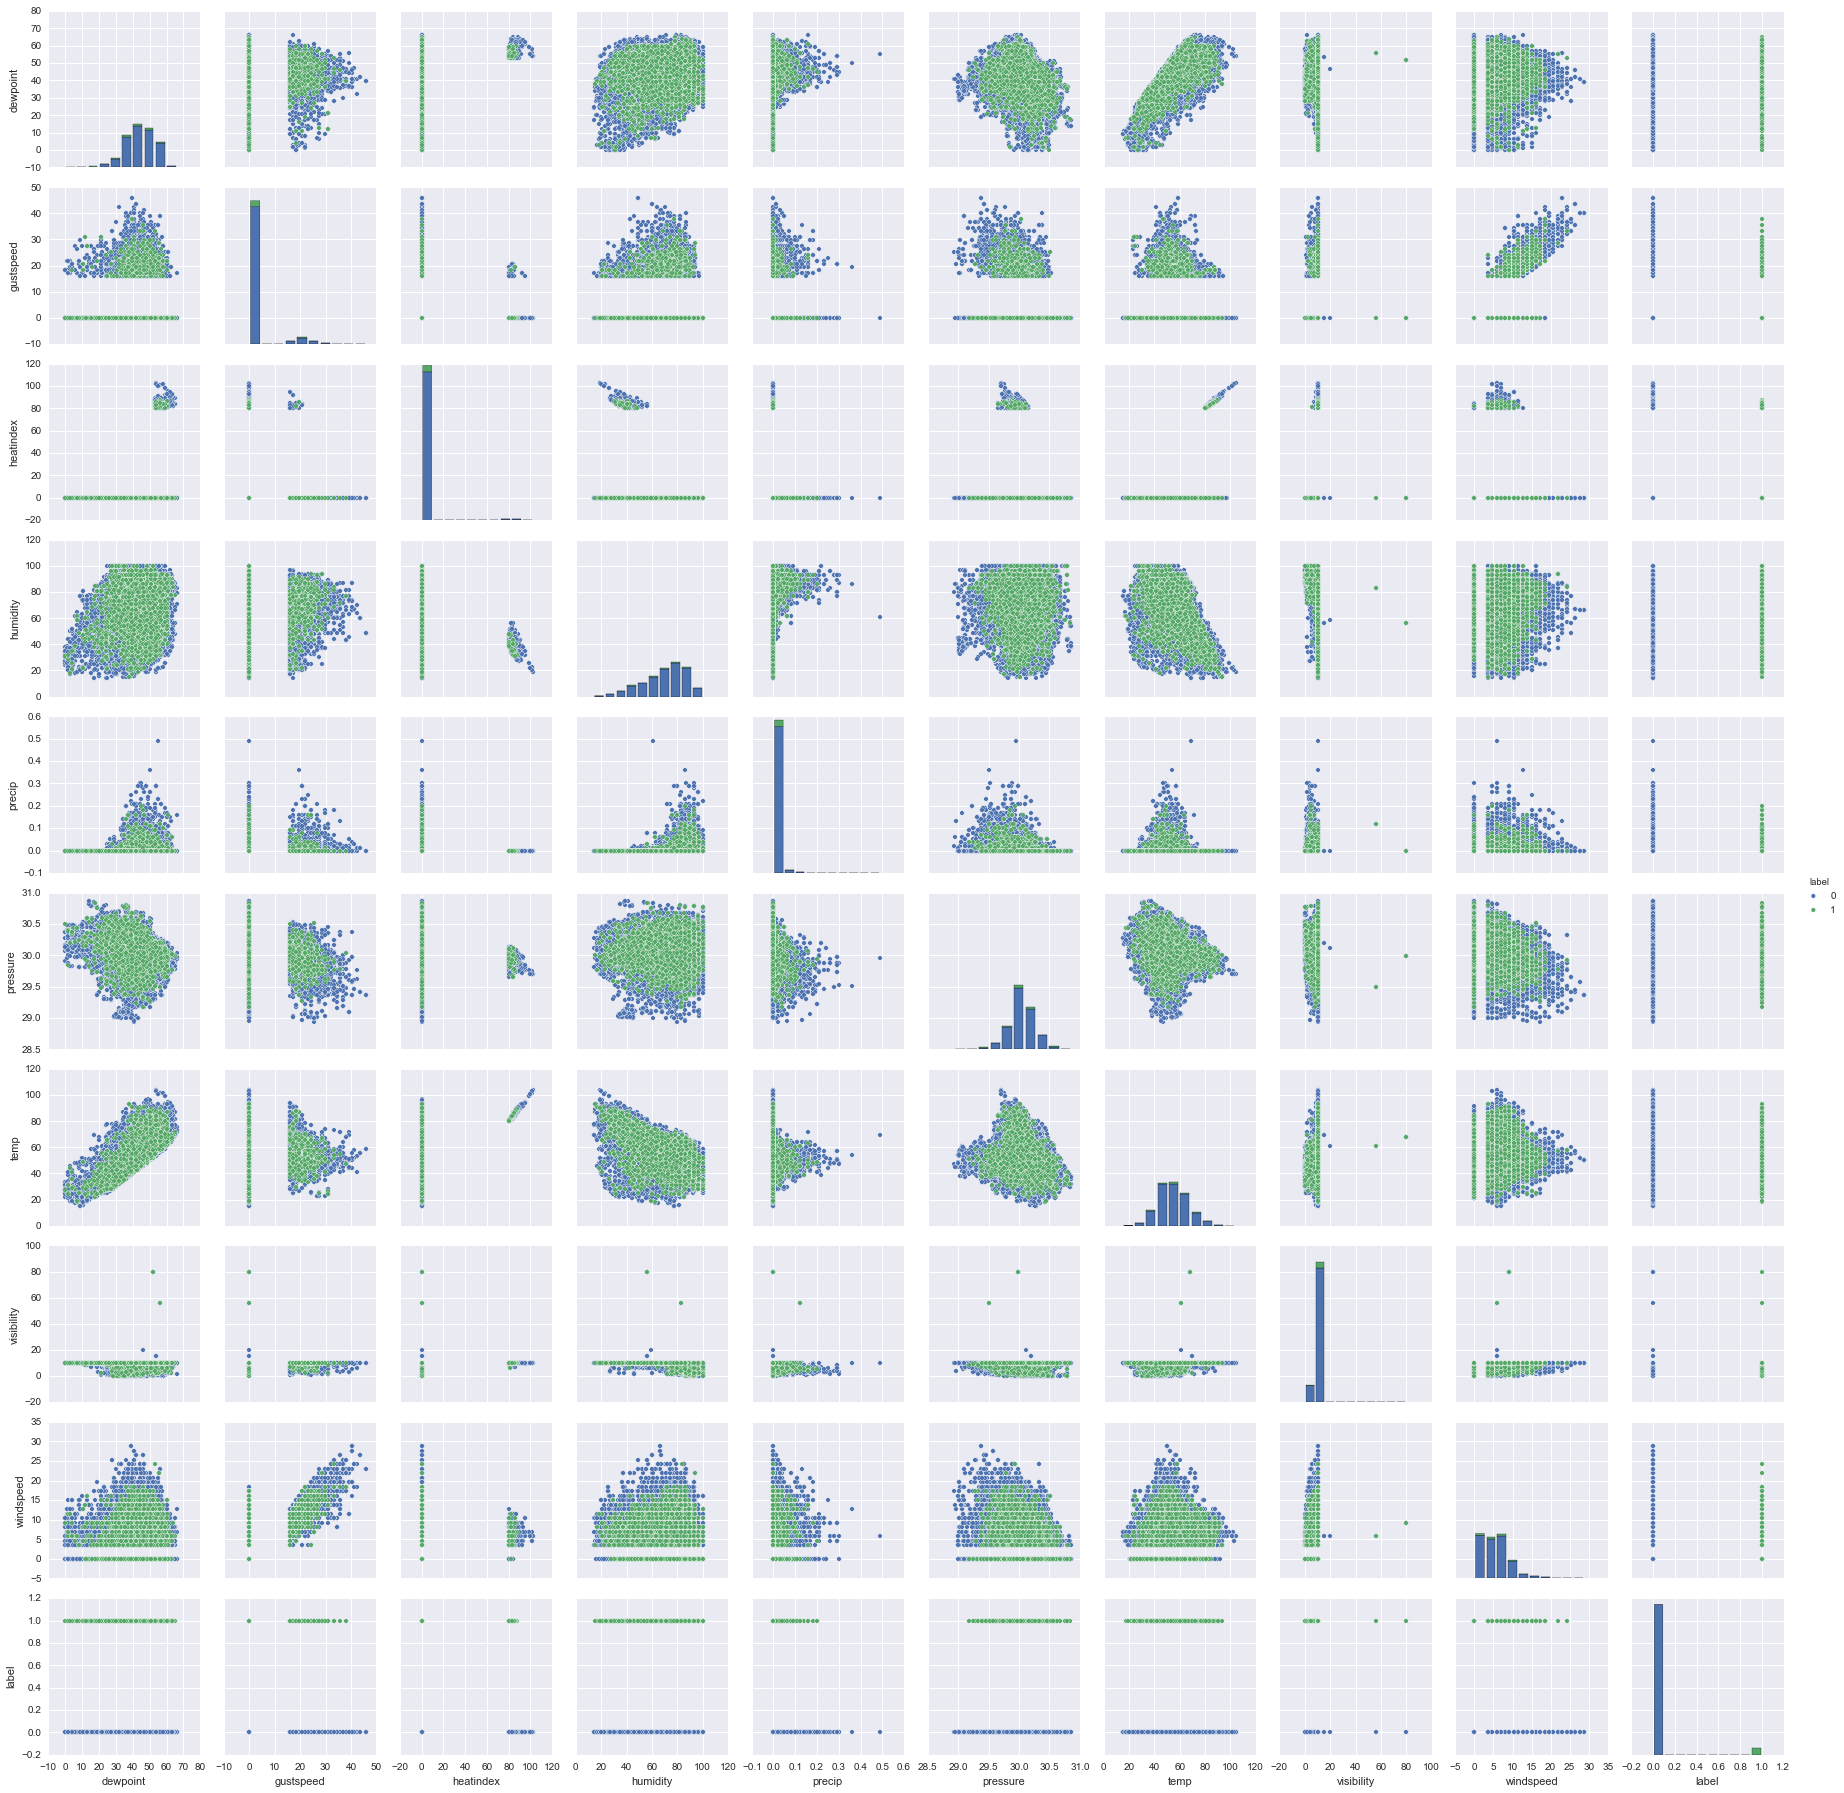

In [41]:
sns.set()
sns.pairplot(df3, hue='label')

In [15]:
df2_pos = df2[df2.label == 1]
df2_neg = df2[df2.label == 0]

zone_beat_id


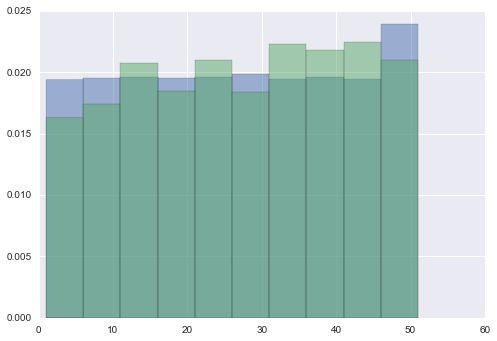

condition_id


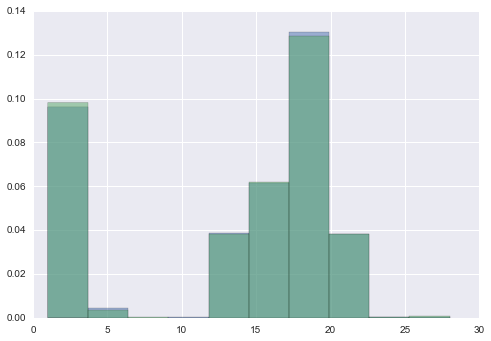

winddir_id


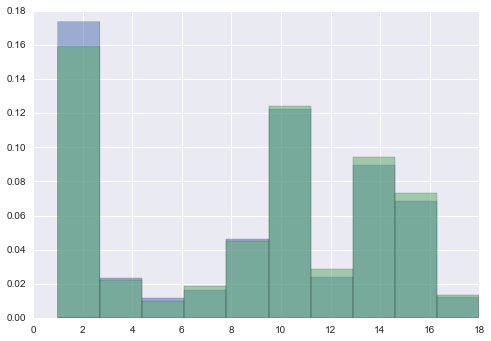

hour


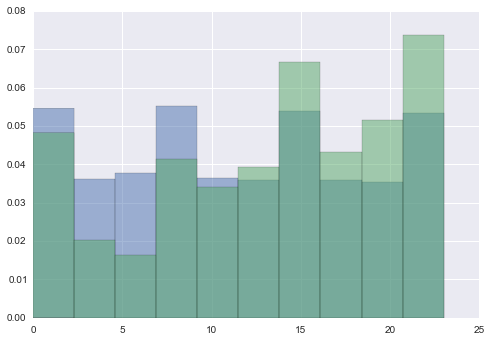

dow


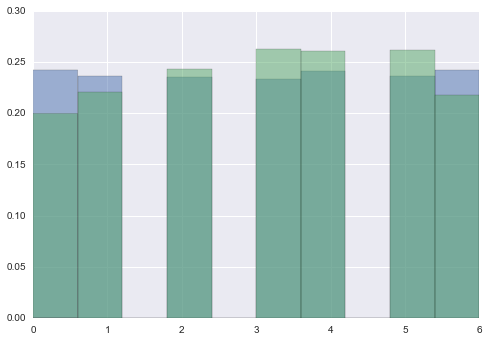

month


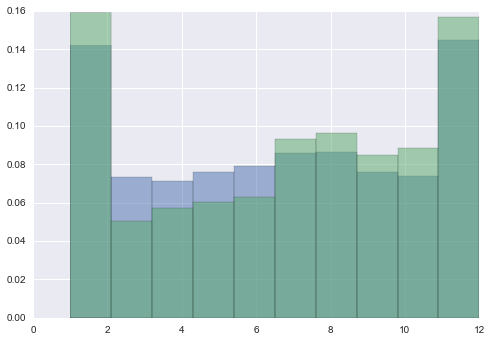

mariner_plays


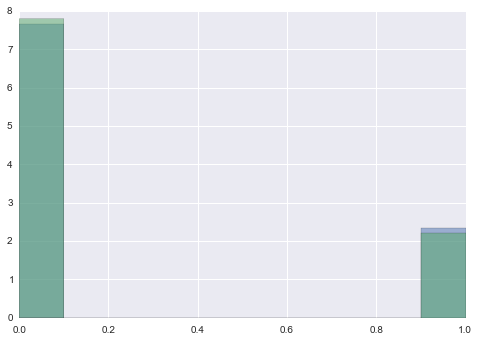

seahawk_plays


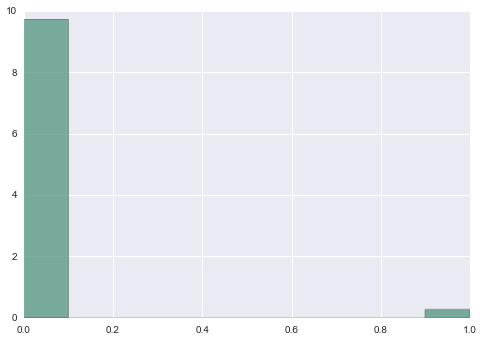

dewpoint


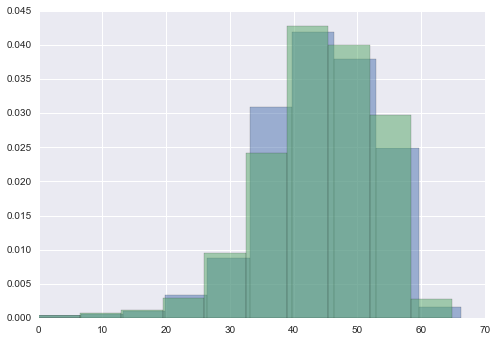

gustspeed


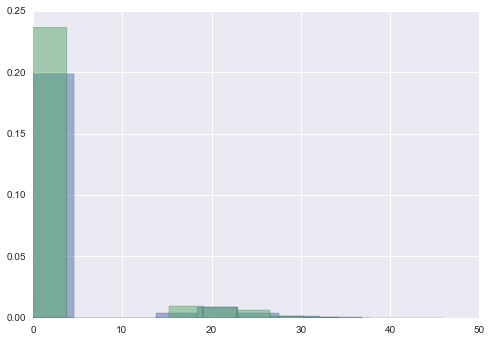

heatindex


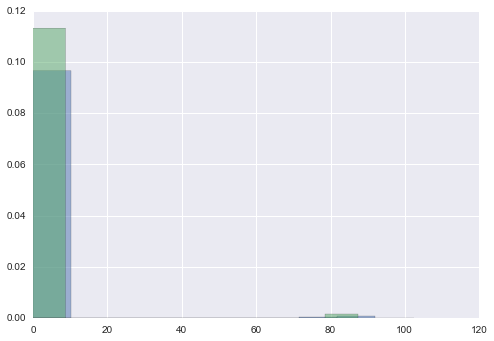

humidity


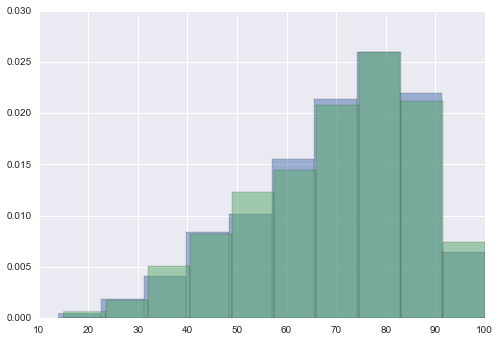

precip


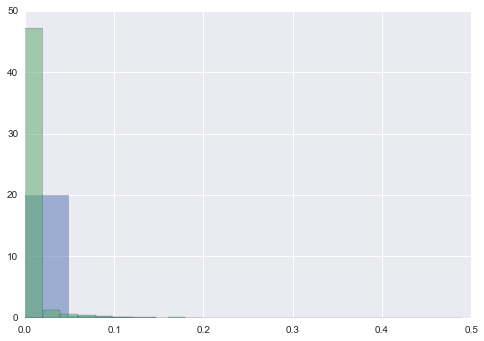

pressure


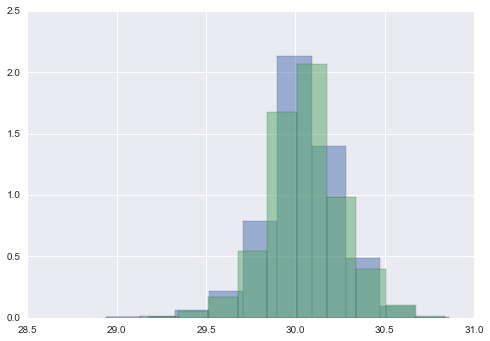

temp


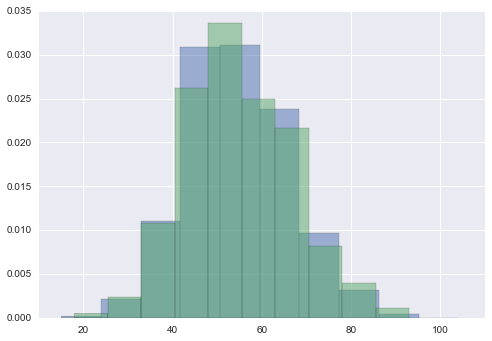

visibility


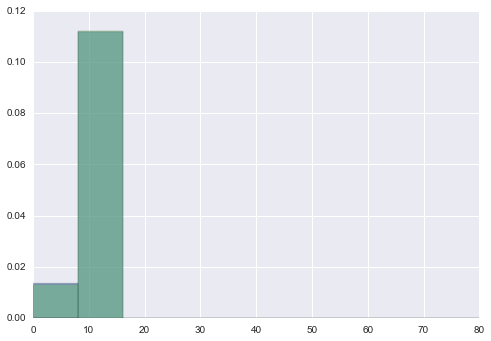

windspeed


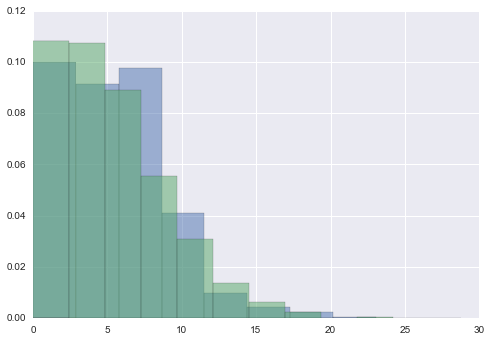

label


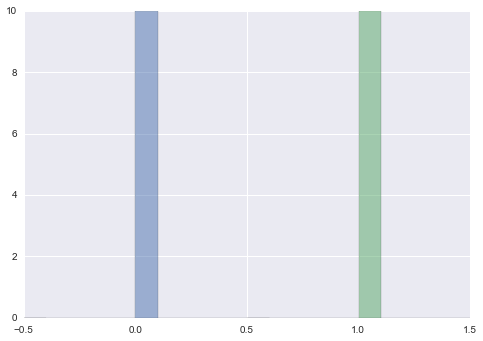

In [38]:
for col in df2.columns:
    print col
    plt.hist(df2_neg[col].values, alpha=0.5, label='0', normed=True)
    plt.hist(df2_pos[col].values, alpha=0.5, label='1', normed=True)
    plt.show()

In [39]:
print '0 label count:', df2[df2.label == 0]['label'].count()
print '1 label count:', df2[df2.label == 1]['label'].count()

0 label count: 95828
1 label count: 4172


In [42]:
y = df2.pop('label').values
df2.sort(axis=1).head().T

KeyError: 'label'

In [43]:
X = df2.sort(axis=1).values

#### Doesn't look great... lets just try some models

In [44]:
encoder = OneHotEncoder(categorical_features=[0, 2, 5, 8, 14, 16])
mat = encoder.fit_transform(X)

In [45]:
logit = LogisticRegression(class_weight='auto')

In [46]:
cvs = cross_val_score(logit, mat, y, scoring='roc_auc', cv=5)

In [76]:
cvs

array([ 0.64143209,  0.63965193,  0.64007896,  0.65148968,  0.65017099])

In [77]:
np.mean(cvs)

0.64456473003574921

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [79]:
encoder = OneHotEncoder(categorical_features=[0, 2, 8, 14, 16])
mat_train = encoder.fit_transform(X_train)
logit = LogisticRegression(class_weight='auto').fit(mat_train, y_train)
mat_test = encoder.transform(X_test)

In [80]:
predict = logit.predict(mat_test)
roc_auc_score(predict, y_test)

0.51463747801569037

In [81]:
bayes = GaussianNB()
cvs = cross_val_score(bayes, mat.toarray(), y, scoring='roc_auc', cv=5)

In [82]:
cvs

array([ 0.52244292,  0.52133458,  0.51170063,  0.52028902,  0.52780394])

In [83]:
np.mean(cvs)

0.52071421732529077

In [84]:
bayes.fit(mat_train.toarray(), y_train)
roc_auc_score(bayes.predict(mat_test.toarray()), y_test)

0.51211615562435897

In [85]:
rnf = RandomForestClassifier(class_weight='auto', n_estimators=200)

In [86]:
cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.60302986  0.60462056  0.601333    0.57352486  0.59309604  0.60511212
  0.60276123  0.62719092  0.57718771  0.60724658]
0.59951028594


In [87]:
rnf.fit(X_train, y_train)
roc_auc_score(rnf.predict(X_test), y_test)

0.5219112811220723

In [88]:
gbc = GradientBoostingClassifier()

In [89]:
cvs = cross_val_score(gbc, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.62004824  0.66465392  0.64178163  0.60524629  0.62305099  0.64098278
  0.64046002  0.66600763  0.64037911  0.65804181]
0.640065242766


In [91]:
gbc.fit(X_train, y_train)
roc_auc_score(gbc.predict(X_test), y_test)

0.48009800980098011

In [92]:
max([x[1] for x in gbc.predict_proba(X_test)])

0.58018992884862486

In [52]:
svc = SVC(class_weight='auto')

In [53]:
cvs = cross_val_score(svc, mat, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.58272633  0.43241415  0.42502601  0.54084287  0.44279396  0.43007479
  0.51169872  0.50307158  0.58277244  0.51404915]
0.496546999653


#### Lets try expanding on RNF

In [68]:
pd.Series([x[1] for x in rnf.predict_proba(X_test)]).unique()

array([ 0.02,  0.08,  0.03,  0.01,  0.04,  0.05,  0.  ,  0.21,  0.06,
        0.09,  0.11,  0.1 ,  0.16,  0.56,  0.24,  0.07,  0.2 ,  0.12,
        0.39,  0.14,  0.13,  0.15,  0.31,  0.34,  0.25,  0.17,  0.18,
        0.36,  0.35,  0.29,  0.43,  0.23,  0.19,  0.32,  0.49,  0.44,  0.52])

In [79]:
auc = []
for n in xrange(10, 101):
    rnf = RandomForestClassifier(class_weight='auto', n_estimators=n)
    cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=5)
    auc.append(np.mean(cvs))

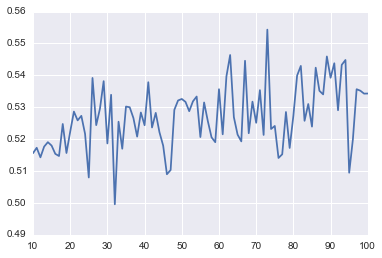

In [80]:
plt.plot(range(10, 101), auc)

In [ ]:
# Grid param modified to only store the ones preferred
random_forest_grid = {
                      'max_depth': [3, 6, 9],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [5, 10, 15],
                      'min_samples_leaf': [5, 10, 15],
                      'bootstrap': [False, True],
                      'n_estimators': [100],
                      'random_state': [None, 20, 200],
                      'class_weight': ['auto']
                     }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X, y)

print "best parameters:", rf_gridsearch.best_params_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


In [207]:
rnf = RandomForestClassifier(class_weight = 'auto')
rnf.fit(X_train, y_train)
rnf_df = pd.DataFrame(X_test, columns=df2.columns)
rnf_df['proba'] = pd.Series([x[1] for x in rnf.predict_proba(X_test)])
rnf_df['label'] = pd.Series(y_test)

In [208]:
rnf_df['proba_bins'] = pd.cut(rnf_df['proba'], bins=3)

In [209]:
roc_auc_score(rnf.predict(X_test), y_test)

0.72995991983967934

In [168]:
rnf_df.head().T

,0,1,2,3,4
zone_beat_id,18,17,18,18,19
condition_id,39.2,37,46.9,51.8,33.1
winddir_id,3,3,5,4,5
hour,0,0,0,21.9,0
dow,0,0,0,0,0
month,7,19,22,14,18
mariner_plays,87,71,69,68,70
seahawk_plays,0,0,0,0,0
dewpoint,12,11,11,7,11
gustspeed,0,0,0,0,0


In [169]:
rnf_df[['proba_bins', 'label']].groupby('proba_bins', as_index=False).agg({'label': ['sum','mean', 'count']})

proba_bins label                
                     sum      mean count
0  (0.025, 0.0749]    75  0.039288  1909
1  (0.0749, 0.125]     6  0.072289    83
2   (0.125, 0.175]     1  0.125000     8